# Forecasting error metrics

In this notebook, we will go through the most popular error metrics for time series forecasting. We will go through the mathematical details and implement them from scratch. As we see in the following diagram, we find four big branches of forecasting error metrics:

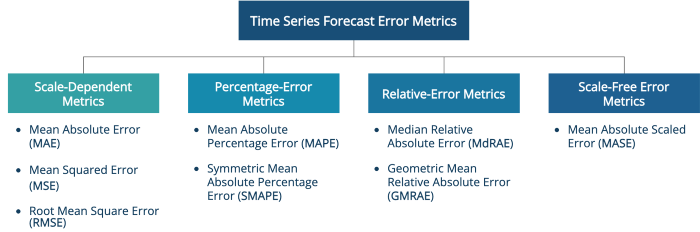

Source: https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27

In this tutorial, we will denote the original time series as $y$, the predicted time series as $\hat{y}$ and $n$ will be the number of timesteps of these time series. To that aim, we will use the time series library *darts* and the *MonthlyMilkDataset*, a time series of the monthly production of milk (in pounds per cow) between January 1962 and December 1975. As forecaster, we will use the Fast Fourier Transform (FFT).

In [1]:
from darts import TimeSeries
from darts.datasets import MonthlyMilkDataset
from darts.models import FFT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

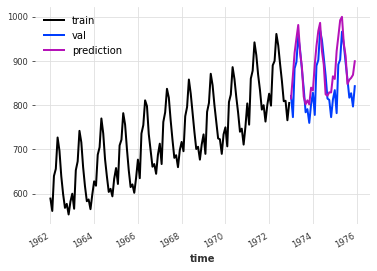

In [2]:
series = MonthlyMilkDataset().load()
train, val = series.split_after(pd.Timestamp("19721201"))
model = FFT(trend="poly")
model.fit(train)
pred_val = model.predict(len(val))
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")

In [3]:
y = val._xa.values.flatten()
y_hat = pred_val._xa.values.flatten()

## 1. Scale-Dependent Metrics

This family of metrics depend on the original scale (units) of the original time series. For example, if we want to forecast the price of you stock time series, these methods will give you a measure as a function of euros or dolars.
* Mean Absolute Error (MAE): $$ MAE(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} |y_i-\hat{y_i}|$$
* Mean Squared Error (MSE): $$ MSE(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i-\hat{y_i})^2$$
* Root Mean Squared Error (RMSE): $$ RMSE(y, \hat{y}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i-\hat{y_i})^2}$$

MSE and RMSE put more weight into outliers and large errors in comparison to MAE. Also, note that due to the squaring, MSE will output the result in squared units. 

In [4]:
def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))

def mse(y, y_hat):
    return np.mean(np.square(y - y_hat))

def rmse(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))

In [5]:
print("MAE: %.4f pounds/cow" %mae(y, y_hat))
print("MSE: %.4f (pounds/cow)²" %mse(y, y_hat))
print("RMSE: %.4f pounds/cow" %rmse(y, y_hat))

MAE: 38.9680 pounds/cow
MSE: 2536.2963 (pounds/cow)²
RMSE: 50.3617 pounds/cow


## 2. Percentage Error Metrics

This family of metrics is scale independent, as the result is expressed as a percentage. They are specially useful to compare time series in different units. Also, they are easily interpretable.

* Mean Absolute Percentage Error (MAPE): $$ MAPE(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} |\frac{y_i-\hat{y_i}}{y_i}*100|$$
* Mean Squared Error (MSE): this metric is the most controversial because it comes with different definitions and because it is not symmetric, as the name suggests.

    * Makridakis (1993): $$ sMAPE(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} \frac{|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2} $$
    * 0-100% adjusted SMAPE: $$ sMAPE(y, \hat{y}) = \frac{100\%}{n} \sum_{i=1}^{n} \frac{|y_i-\hat{y_i}|}{|y_i|+|\hat{y_i}|} $$


MAPE is undefined at time steps with value 0 or close to 0. Also, it is an asymmetric as it puts more weight into negative errors. SMAPE avoids MAPE’s problem of large errors when y-values are close to zero and the large difference between the absolute percentage errors when y is greater than y-hat and vice versa. Unlike MAPE which has no limits, it fluctuates between 0% and 200% (Makridakis and Hibon, 2000). Furthermore, sMAPE is not symmetric. We will see this with an example.
First, let's observe the results for our milk dataset.

In [6]:
def mape(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)*100)

# SMAPE proposed by Makridakis (1993): 0%-200%
def smape_original(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)


# adjusted SMAPE version to scale metric from 0%-100%
def smape_adjusted(a, f):
    return (1/a.size * np.sum(np.abs(f-a) / (np.abs(a) + np.abs(f))*100))

In [7]:
print("MAPE: %.4f %%" %mape(y, y_hat))
print("SMAPE 1993: %.4f %%" %smape_original(y, y_hat))
print("SMAPE Adjusted: %.4f %%" %smape_adjusted(y, y_hat))

MAPE: 4.6741 %
SMAPE 1993: 4.5053 %
SMAPE Adjusted: 2.2527 %


We will see the asymmetry of these methods by inspecting a visual example. Asume that we are in the following scenario:

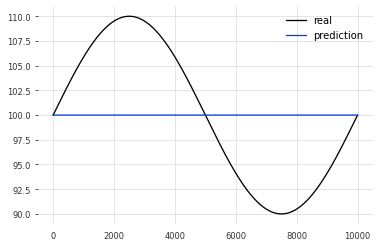

In [8]:
amplitude = 10
frequency = 0.1
start_time = 0
end_time = 10
time = np.arange(start_time, end_time, 1/1000)
z = amplitude * np.sin(2 * np.pi * frequency * time) + 100
z_hat = np.repeat(100.0, len(time))
plt.plot(z, label='real')
plt.plot(z_hat, label='prediction')
plt.legend()
plt.show()

We will measure the error of the first halt and the second half of the sine wave with the the above described metrics. If we follow our intuition, we expect to have the same forecasting error in both halves. However, this is not the case.

In [9]:
print("Evaluation of predictions in first half of period:")
print("MAPE: %.4f %%" %mape(z[:len(z)//2], z_hat[:len(z_hat)//2]))
print("SMAPE 1993: %.4f %%" %smape_original(z[:len(z)//2], z_hat[:len(z_hat)//2]))
print("SMAPE Adjusted: %.4f %%" %smape_adjusted(z[:len(z)//2], z_hat[:len(z_hat)//2]))

print()
print("Evaluation of predictions in second half of period:")
print("MAPE: %.4f %%" %mape(z[len(z)//2:], z_hat[len(z_hat)//2:]))
print("SMAPE 1993: %.4f %%" %smape_original(z[len(z)//2:], z_hat[len(z_hat)//2:]))
print("SMAPE Adjusted: %.4f %%" %smape_adjusted(z[len(z)//2:], z_hat[len(z_hat)//2:]))

Evaluation of predictions in first half of period:
MAPE: 5.9052 %
SMAPE 1993: 6.1264 %
SMAPE Adjusted: 3.0632 %

Evaluation of predictions in second half of period:
MAPE: 6.9128 %
SMAPE 1993: 6.6273 %
SMAPE Adjusted: 3.3136 %


As we can observe, the errors in the second half are higher.

## 3. Relative Error Metrics 

These error metrics measure your model performance against others, or against a baseline or benchmark model. For example, a baseline model can be a copy of the last time steps to produce a prediction. In our case this would be:

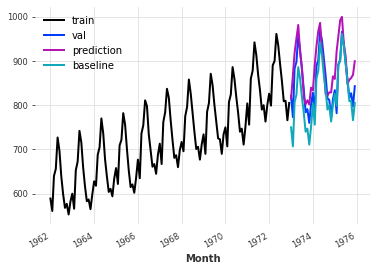

In [10]:
series = MonthlyMilkDataset().load()
train, val = series.split_after(pd.Timestamp("19721201"))
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")
baseline = TimeSeries.from_times_and_values(val._time_index, train[-len(val):]._xa.values.flatten())
benchmark = baseline._xa.values.flatten()
baseline.plot(label='baseline')

Some common baseline methods are the naive and seasonal naive forecasters, or the mean of previous observations. There are two important relative error metrics:
* Median Relative Absolute Error (MdRAE): 
$$ MdRAE(y, \hat{y}, b) = Median_{i=1, n}\left(\frac{|y_i - \hat{y_i}|}{|y_i-b_i|}\right)$$
$$b_i = 
     \begin{cases}
       y_{t-1} & \text{Non-seasonal}\\
       y_{t-M} & \text{Seasonal}\\
     \end{cases} $$ where $b_i$ is the benchmark result and $M$ is the seasonal period in the time series. 
* Explain Geometric Mean Relative Absolute Error (GMRAE):
$$ GMRAE(y, \hat{y}, b) = exp\left( \frac{1}{n}\sum_{i=1}^n\ln\left(\frac{|y_i - \hat{y_i}|}{|y_i-b_i|}\right)\right) = \sqrt{\prod_{i=1}^n\left(\frac{|y_i - \hat{y_i}|}{|y_i-b_i|}\right)}$$
$$b_i = 
     \begin{cases}
       y_{t-1} & \text{Non-seasonal}\\
       y_{t-M} & \text{Seasonal}\\
     \end{cases} $$ where $b_i$ is the benchmark result and $M$ is the seasonal period in the time series. 

Both metrics output 1 if the benchmark is equal to forecast. If the benchmark forecast is better, then the result will be greater than 1, and vice versa. As these metrics takes into account the median (MDRAE) or the geometric mean (GMRAE), they are quite resistant to outliers. However, they present undefinite values when the denominator is 0.

In [11]:
def mdrae(y, y_hat, bnchmrk):
    return np.median(np.abs(y - y_hat)/np.abs(y - bnchmrk))

def gmrae(y, y_hat, bnchmrk):
    
    abs_scaled_errors = np.abs(y - y_hat)/np.abs(y - bnchmrk)
    return np.exp(np.mean(np.log(abs_scaled_errors)))

In [12]:
print("MDRAE: %.4f" %mdrae(y, y_hat, benchmark))
print("GMRAE: %.4f" %gmrae(y, y_hat, benchmark))

MDRAE: 1.3565
GMRAE: 1.2532


## 4. Scale-Free Error Metrics

Their idea of this metrics is to scale the error based on the in-sample MAE from a naive (random walk) forecast method. 
* Mean Absolute Scaled Error (MASE):
$$ MASE(y, \hat{y}) = \frac{MAE}{MAE_{\text{in-sample, naive}}} = \frac{\frac{1}{n} \sum_{i=1}^{n} |y_i-\hat{y_i}|}{\frac{1}{T-1} \sum_{i=2}^{T} |y_t-\hat{y_{t-1}}|}$$

The MASE is calculated by taking the MAE and dividing it by the MAE of an in-sample (so based on our training data) naive benchmark. We can also consider the seasonal naive model al benchmark

Values of MASE greater than 1 indicate that the forecasts are worse, on average, than in-sample one-step forecasts from the naive model (Hyndman and Koehler, 2006). Since it is a scale free metric one is able to compare the model’s accuracy across (scale) different time series.

In [13]:
def mase(y, y_hat, y_train):
    ## MAE
    mae = np.mean(np.abs(y - y_hat))
    
    ## Naive in-sample Forecast
    naive_y_hat = y_train[:-1] #all values except the last one
    naive_y = y_train[1:] #all values except the frist one

    ## Calculate MAE (in sample)
    mae_in_sample = np.mean(np.abs(naive_y - naive_y_hat))
    
    return mae/mae_in_sample

In [14]:
def seasonal_mase(y, y_hat, y_train, m):
    ## MAE
    mae = np.mean(np.abs(y - y_hat))
    
    ## Naive in-sample Forecast
    naive_y_hat = y_train[:-m] #all values except the last one
    naive_y = y_train[m:] #all values except the frist one

    ## Calculate MAE (in sample)
    mae_in_sample = np.mean(np.abs(naive_y - naive_y_hat))
    
    return mae/mae_in_sample

In [15]:
y_train = train._xa.values.flatten()
print("MASE: %.4f" %mase(y, y_hat, y_train))
print("Seasonal MASE: %.4f" %seasonal_mase(y, y_hat, y_train, 12))

MASE: 1.0173
Seasonal MASE: 1.6276


# Summary

As we saw, there are different forecasting error metrics and depending on the use case one or the other might be prefered. 